In [1]:
import numpy as np
import scipy.stats as stats
from scipy import signal
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [2]:
results_paths={}
# results_paths['aud_target_correct_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_target_correct_trials_5ms_bin_50ms_window_20251108_000039/"
# results_paths['vis_target_correct_trials'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_50ms_window_20251107_235739/"

results_paths['aud_target_correct_trials_10'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_target_correct_trials_5ms_bin_50ms_window_10units_0/"
results_paths['vis_target_correct_trials_10'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_50ms_window_10units_0/"
results_paths['aud_target_correct_trials_20'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_target_correct_trials_5ms_bin_50ms_window_20251108_000039/"
results_paths['vis_target_correct_trials_20'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_50ms_window_20251107_235739/"
results_paths['aud_target_correct_trials_30'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_aud_target_correct_trials_5ms_bin_50ms_window_30units_0/"
results_paths['vis_target_correct_trials_30'] = r"s3://aind-scratch-data/dynamic-routing/decoding/results/decode_context_baseline_subtract_vis_target_correct_trials_5ms_bin_50ms_window_30units_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.272.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_engaged'),
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle keep_original_structure
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)

# map structures to grouped structures
# SCop, SCsg, SCzo -> SCs
# SCig, SCiw, SCdg, SCdw -> SCm
# ECT1, ECT2/3, ECT6b, ECT5, ECT6a, ECT4 -> ECT
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}



In [5]:
# session-wise average decoding accuracy

def get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping):

    new_results_session_df = (
        pl.scan_parquet(results_path)
        .filter(
            pl.col('session_id').is_in(dr_session_list),
        )
        .with_columns(
            pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
        )
        .filter(
            combine_multi_probe_expr,
            pl.col('is_all_trials').not_(),
        )
        #get total n units
        .join(
            other=(
                pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.272/consolidated/units.parquet')
                .with_columns(
                    pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                )
                #make new rows according to structure_grouping
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                    .then(pl.col('structure').repeat_by(n_repeats))
                    .otherwise(pl.col('structure').repeat_by(1))
                )
                .explode('structure')
                .with_columns(
                    pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                    .then(pl.col('structure').replace(structure_grouping))
                    .otherwise(pl.col('structure'))
                )
                .group_by('session_id','structure')
                .agg(
                    pl.col('unit_id').len().alias('total_n_units')
                )
            ),
            on=['session_id','structure'],
            how='left',
        )
        #join on session table to get cross-modal dprime, etc.
        .join(
            other=session_table.filter(
                pl.col('session_id').is_in(dr_session_list)
            ).select(
                'session_id',
                'n_passing_blocks',
                'cross_modality_dprime_vis_blocks',
                'cross_modality_dprime_aud_blocks',
            ).lazy(),
            on='session_id',
            how='left',
        )
        # get the means for each recording over repeats:
        .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
        .agg(
            pl.col('balanced_accuracy_test').mean(), # over repeats
        )
        # get the aligned result and median over shifts:
        .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                            'cross_modality_dprime_aud_blocks', 'total_n_units'})
        .agg(
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
            pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
            pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
        )
        # get the difference between true and null:
        .with_columns(
            pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
        )
        .sort('structure', 'unit_subsample_size', descending=False)
        .collect()
    )

    return new_results_session_df.to_pandas()

In [ ]:
results_dfs={}
for key, results_path in results_paths.items():
    print(f"Loading results from {key}...")
    results_dfs[key] = get_results_df(results_path, dr_session_list, session_table, grouping_cols, combine_multi_probe_expr, n_repeats, structure_grouping)

In [ ]:
# save individual dfs from resuts_dfs as parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare_latency_of_decoding_context-2025-11-10"

for key, df in results_dfs.items():
    df.to_parquet(os.path.join(savepath, f"{key}_decoding_summary_table.parquet"))



In [6]:
#load results from parquet files
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare_latency_of_decoding_context-2025-11-10"
results_dfs={}
for filename in os.listdir(savepath):
    if filename.endswith("_decoding_summary_table.parquet"):
        key = filename.replace("_decoding_summary_table.parquet", "")
        df = pd.read_parquet(os.path.join(savepath, filename))
        results_dfs[key] = df

In [ ]:
# plot average across sessions by structure

# sel_structure="AId"
# sel_unit_subsample_size='all'
# sel_time_aligned_to="response_or_reward_time"
sel_time_aligned_to="stim_start_time"
# time_offset=0.025 #add to bin_centers

# sel_key_set='all_trials'


key_sets={
    # 'stimulus_specific_results':['vis_target_correct_trials', 'aud_target_correct_trials']
    'stimulus_specific_results':['vis_target_correct_trials_10', 'aud_target_correct_trials_10',
                                'vis_target_correct_trials_20', 'aud_target_correct_trials_20',
                                'vis_target_correct_trials_30', 'aud_target_correct_trials_30'],
}

# savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-10-07-decode_split_by_stim_modality\by_area"

for sel_key_set in key_sets.keys():

    for sel_structure in results_dfs[key]['structure'].unique():
        sel_structure='MRN'

        fig,ax=plt.subplots(1,1,figsize=(8,4))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        # ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        for key in key_sets[sel_key_set]:
            if 'cumulative' in key:
                time_offset=0.0
            else:
                time_offset=0.025    
            new_results_session_pd = results_dfs[key]
            bins=np.sort(new_results_session_pd['bin_center'].unique())

            print(f"Plotting results from {key}...")

            example_timebin_decoding=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
            # if key=='context_baseline_subtract_cumulative_0.01':
            #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
            # else:
            ax.plot(bins+time_offset, example_timebin_decoding, label=key)

        # ax.set_ylim(0.5,1)

        # ax.set_xlim(-0.1,0.65)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        ax.set_title(f"{sel_structure} ({n_sessions}); {sel_time_aligned_to}")

        fig.tight_layout()
        
        # fig.savefig(os.path.join(savepath, f"{sel_structure}_{sel_key_set}.png"), dpi=300)
        # plt.close(fig)
        break


In [47]:
#compare each result across strutures

# sel_structures=['AUDp','VISp','ACAd','MOs','MOp','ORBl','PL','CP','SCm','MRN']
# sel_structures=['AUDp','VISp','ACAd','MOs','ORBl','RT','CP','SCm','MRN','GPe','RT','VTA','SNr']

# sel_structures=['SCm','ACAd','MOs','PL','ORBl','FRP','AId','MOp','SSp','AUDp','VISp'] #ctx
# sel_structures=['SCm','SCs','MRN','PAG','APN','CP','GPe','VTA','SNr'] #mb
# sel_structures=['SCm','MD','RT','VAL','VPL','ZI','VL','POL','LGd','MGd'] #thal

structure_sets={
    # 'cortex': ['ACAd','MOs','PL','ORBl','FRP','AId','MOp','SSp','AUDp','VISp'],
    # 'mb_bg': ['SCm','SCs','MRN','PAG','APN','CP','GPe','VTA','SNr'],
    # 'thalamus': ['MD','RT','VAL','VPL','ZI','VL','POL','VPM','LGd','MGd'],

    # 'custom': ['SCm','MRN','MOs','ACAd','ORBl','VTA','VAL','MD','GPe'],
    'custom_1': ['MRN','SCm','CP','SSp','MOs','FRP','ACAd','ORBl']
}

# sel_structures=['AId','FRP','PL','ORBl','GPe','VTA','MD','RT']


time_offset=0.025 #add to bin_centers
# sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_or_reward_time"
# # sel_result='response_vis_target' #context_all_trials, context_aud_target, context_vis_target, response_all_trials, response_aud_target, response_vis_target
# sel_result='context_vis_target' #'aud_stim_in_aud_context' #context_all_trials_no_baseline_subtract
# sel_result='context_no_baseline_subtract_aud_stim_10units'
# sel_result='response_aud_stim_10units'

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC"

color_list=plt.cm.tab10.colors

for key in results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.025

    for set_name in structure_sets.keys():
        sel_structures = structure_sets[set_name]

        # fig,ax=plt.subplots(1,1,figsize=(8,4))
        fig,ax=plt.subplots(1,1,figsize=(5,3))
        ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
        # ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
        ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

        bins=np.sort(results_dfs[key]['bin_center'].unique())

        for ss,sel_structure in enumerate(sel_structures):

            n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

            new_results_session_pd = results_dfs[sel_result]

            example_timebin_decoding=[]

            for bb in bins:
                ####have to do something more complicated here to reshape
                example_timebin_decoding.append(new_results_session_pd.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].mean())
            # if key=='context_baseline_subtract_cumulative_0.01':
            #     ax.plot((example_timebin_decoding['bin_center']*2+.095).values, example_timebin_decoding['mean_true'], label=key)
            # else:
            if ss<len(color_list):
                line_style='-'
            if ss>len(color_list)-1:
                ss=ss-len(color_list)
                line_style='--'

            ax.plot(bins+time_offset, example_timebin_decoding, label=f"{sel_structure} ({n_sessions})", color=color_list[ss], linestyle=line_style)

            # ax.set_ylim(0.5,1)

        # ax.set_xlim(-0.1,0.65)
        ax.set_xlabel('time rel to stim onset (s)')
        ax.set_ylabel('decoding accuracy')
        #place legend outside
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        # ax.legend()
        if set_name=='mb_bg':
            temp_set_name='midbrain & basal ganglia'
        else:
            temp_set_name=set_name
        ax.set_title(f"{sel_result}; {temp_set_name}")#;\n{sel_unit_subsample_size} units")

        #remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        fig.tight_layout()
        fig.savefig(os.path.join(savepath, f"decode_{sel_result}_{set_name}.png"), dpi=300)

        # ax.set_xlim(0,0.2)
        # fig.savefig(os.path.join(savepath, f"decode_{sel_result}_{set_name}_zoom.png"), dpi=300)

        plt.close(fig)

        # break

In [ ]:
#latency of mean traces

#save average by structure/result plots, compute time to half max, max value, etc.
# 
# time_offset=0.025 #add to bin_centers
sel_unit_subsample_size='all'
sel_time_aligned_to="stim_start_time"

mean_result_by_structure={
    'structure': [],
    'result': [],
    'n_sessions': [],
    'bin_centers': [],
    'mean_decoding_accuracy': [],
    'sem_decoding_accuracy': [],
    'max_decoding_accuracy': [],
    'time_to_max': [],
    'time_to_90_pct': [],
    'time_to_75_pct': [],
    'time_to_half_max': [],
    'time_to_significance': [],
    
}

sel_keys=['aud_target_correct_trials', 'vis_target_correct_trials']

for key in sel_keys:#results_dfs.keys():
    sel_result=key
    if 'cumulative' in key:
        time_offset=0.0
    else:
        time_offset=0.025

    for sel_structure in results_dfs[key]['structure'].unique():

        n_sessions=results_dfs[key].query(f'structure=="{sel_structure}"')['session_id'].nunique()

        if n_sessions < 3:
            continue

        new_results_session_pd = results_dfs[sel_result]

        temp_df=new_results_session_pd.query(
            f'structure=="{sel_structure}" and time_aligned_to=="{sel_time_aligned_to}"'
            ).sort_values(
                ['session_id','bin_center']
            ).groupby(['session_id'])

        decoding_result=np.vstack(temp_df['mean_true'].apply(np.array).values)
        bins=temp_df['bin_center'].apply(np.array).values[0].round(3)

        example_timebin_decoding=np.nanmean(decoding_result, axis=0)
        example_timebin_decoding_sem=stats.sem(decoding_result, axis=0, nan_policy='omit')

        max_decoding_accuracy=example_timebin_decoding.max()

        time_to_max=bins[example_timebin_decoding.argmax()]+time_offset
        half_max_value=(max_decoding_accuracy-0.5).max()/2 +0.5
        time_to_half_max=bins[np.where(example_timebin_decoding >= half_max_value)[0][0]]+time_offset

        pct_75_value=(max_decoding_accuracy-0.5).max()*0.75 +0.5
        time_to_75_pct=bins[np.where(example_timebin_decoding >= pct_75_value)[0][0]]+time_offset

        pct_90_value=(max_decoding_accuracy-0.5).max()*0.9 +0.5
        time_to_90_pct=bins[np.where(example_timebin_decoding >= pct_90_value)[0][0]]+time_offset
        
        for bb, acc, sem in zip(bins, example_timebin_decoding, example_timebin_decoding_sem):
            #check if significantly above chance (0.5) using Wilcoxon signed-rank test
            if stats.wilcoxon(decoding_result[:,np.where(bins==bb)[0][0]]-0.5, nan_policy='omit').pvalue < 0.001:
                time_to_significance=bb+time_offset
                break
        else:
            time_to_significance=np.nan

        mean_result_by_structure['structure'].append(sel_structure)
        mean_result_by_structure['result'].append(sel_result)
        mean_result_by_structure['n_sessions'].append(n_sessions)
        mean_result_by_structure['bin_centers'].append((bins+time_offset).round(3))
        mean_result_by_structure['time_to_significance'].append(time_to_significance)
        mean_result_by_structure['mean_decoding_accuracy'].append(example_timebin_decoding)
        mean_result_by_structure['sem_decoding_accuracy'].append(example_timebin_decoding_sem)
        mean_result_by_structure['max_decoding_accuracy'].append(max_decoding_accuracy)
        mean_result_by_structure['time_to_max'].append(time_to_max)
        mean_result_by_structure['time_to_half_max'].append(time_to_half_max)
        mean_result_by_structure['time_to_75_pct'].append(time_to_75_pct)
        mean_result_by_structure['time_to_90_pct'].append(time_to_90_pct)
        # print(f"Processed {sel_structure} for {sel_result} ({n_sessions} sessions)")

mean_result_by_structure_df=pd.DataFrame(mean_result_by_structure)


In [ ]:
# mean_result_by_structure_df.to_parquet(os.path.join(savepath, f"mean_result_by_structure.parquet"))
mean_result_by_structure_df

In [ ]:
sel_keys=[
    'aud_target_correct_trials',
    'vis_target_correct_trials',
]

structure_exclude_list=['TH','MB','SCig','SCiw','SCop','SCsg','SCzo','SCdg','SCdw']

# plot_col='time_to_90_pct'
# plot_col='time_to_75_pct'
plot_col='time_to_half_max'
min_n_sessions=4

set_min_decoding_accuracy=0.65

sel_results_by_structure={
    'structure':mean_result_by_structure_df.query(
        f"result=='{sel_keys[0]}' and n_sessions>=@min_n_sessions and \
        max_decoding_accuracy>=@set_min_decoding_accuracy and \
        structure not in @structure_exclude_list").sort_values(by=plot_col)['structure'].values,
}

# (max_decoding_accuracy>=@set_min_decoding_accuracy or structure=='VISp') and \

sel_structures=sel_results_by_structure['structure']

for sel_key in sel_keys:
    
    sel_results_by_structure[sel_key]=[]

    for sel_structure in sel_structures:
        temp_df=mean_result_by_structure_df.query(
            f"result=='{sel_key}' and structure=='{sel_structure}' and n_sessions>=@min_n_sessions")
        if len(temp_df)==1:
            sel_results_by_structure[sel_key].append(temp_df[plot_col].values[0])
        else:
            sel_results_by_structure[sel_key].append(np.nan)
    
sel_results_by_structure_df=pd.DataFrame(sel_results_by_structure)

fig,ax=plt.subplots(1,1,figsize=(12,4))
sorted_df=sel_results_by_structure_df.sort_values(by=sel_keys[0]).dropna()
sorted_df.plot.bar(x='structure', y=sel_keys, ax=ax)
ax.set_ylabel(f"{plot_col} (s)")
ax.set_title("decoding latencies")

In [ ]:
#cross correlation of across-session means?

In [ ]:
#cross correlation of decoding accuracy across simultaneously recorded structures

# start with one session

# sel_session="664851_2023-11-13"
sel_session="742903_2024-10-22"
sel_result='vis_target_correct_trials'
sel_time_aligned_to="stim_start_time"

session_results = results_dfs[sel_result].query(f'session_id=="{sel_session}" and time_aligned_to=="{sel_time_aligned_to}"')

session_results

In [ ]:
bins=np.sort(session_results['bin_center'].unique())
session_structure_decoding_accuracy = {
    'structure': [],
    'mean_true': [],
    'bin_center': [],
}

for sel_structure in session_results['structure'].unique():

    example_timebin_decoding=[]

    for bb in bins:
        ####have to do something more complicated here to reshape
        example_timebin_decoding.append(session_results.query(f'structure=="{sel_structure}" and \
                                        time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].values[0])
        
    session_structure_decoding_accuracy['structure'].append(sel_structure)
    session_structure_decoding_accuracy['mean_true'].append(example_timebin_decoding)
    session_structure_decoding_accuracy['bin_center'].append(bins)

session_structure_decoding_accuracy = pd.DataFrame(session_structure_decoding_accuracy)

session_structure_decoding_accuracy

In [ ]:
structure_1='ACAd'
structure_2='ILA'

#limit one array for cross correlation
min_bin=0.025
max_bin=0.100

bin_mask = (bins>=min_bin) & (bins<=max_bin)

mean_true_1 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_1}"')['mean_true'].values[0])
mean_true_2 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_2}"')['mean_true'].values[0])

# mean_true_1 = mean_true_1-np.mean(mean_true_1)
# mean_true_2 = mean_true_2-np.mean(mean_true_2)
# mean_true_1 = mean_true_1-np.min(mean_true_1)
# mean_true_2 = mean_true_2-np.min(mean_true_2)

zero_ind=np.where(bin_mask==True)[0][0]

# corr=np.correlate(mean_true_1[bin_mask], mean_true_2, mode='valid')
# corr = signal.correlate(mean_true_1[bin_mask], mean_true_2, mode='valid')

#do correlation manually
n_valid_lags=len(mean_true_2) - len(mean_true_1[bin_mask]) + 1
corr = np.zeros(n_valid_lags)
for i in range(n_valid_lags):
    corr[i] = stats.pearsonr(mean_true_1[bin_mask], mean_true_2[i:i+len(mean_true_1[bin_mask])])[0]

adjusted_lags = np.arange(corr.size) - zero_ind
lag_times = adjusted_lags * 0.005

max_correlation_index = np.argmax(corr)
best_lag = lag_times[max_correlation_index]

fig,ax=plt.subplots(2,1,figsize=(5,5))

ax[0].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(bins[bin_mask], mean_true_1[bin_mask], label=structure_1)
ax[0].plot(bins, mean_true_2, label=structure_2)
ax[0].set_xlabel('time rel to stim onset (s)')
ax[0].set_ylabel('decoding accuracy')
ax[0].set_title(f"Session {sel_session}")
ax[0].legend()

ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
# ax[1].plot(lag_times, corr)
ax[1].plot(lag_times, corr,)
ax[1].plot(best_lag, corr[max_correlation_index], 'ro',)
ax[1].set_xlabel('lag (s)')
ax[1].set_ylabel('correlation')
ax[1].set_title(f"Peak lag: {best_lag:.3f} s")

fig.tight_layout()

# ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)

In [ ]:
#try correlating the whole trace but only use valid points, limit number of shifts
structure_1='ACAd'
structure_2='ACAv' #second structure is shifted relative to first

#limit n shifts for cross correlation
n_shifts=20

valid_lags=np.arange(-n_shifts, n_shifts+1)

mean_true_1 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_1}"')['mean_true'].values[0])
mean_true_2 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_2}"')['mean_true'].values[0])

zero_ind=np.where(valid_lags==0)[0][0]

#do correlation manually
corr = np.full(len(valid_lags),np.nan)

###double check this is right!

for i, lag in enumerate(valid_lags):
    if lag < 0:
        corr[i] = stats.pearsonr(mean_true_1[:len(mean_true_1)+lag], mean_true_2[-lag:len(mean_true_1)])[0]
    elif lag > 0:
        corr[i] = stats.pearsonr(mean_true_1[lag:len(mean_true_1)], mean_true_2[:len(mean_true_1)-lag])[0]
    else:
        corr[i] = stats.pearsonr(mean_true_1, mean_true_2)[0]
        

lag_times = valid_lags * 0.005

max_correlation_index = np.argmax(corr)
best_lag = lag_times[max_correlation_index]

fig,ax=plt.subplots(3,1,figsize=(5,7))

ax[0].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].plot(bins, mean_true_1, label=structure_1)
ax[0].plot(bins, mean_true_2, label=structure_2)
ax[0].set_xlabel('time rel to stim onset (s)')
ax[0].set_ylabel('decoding accuracy')
ax[0].set_title(f"Session {sel_session}")
ax[0].legend()

ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
# ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
# ax[1].plot(lag_times, corr)
ax[1].plot(lag_times, corr,)
ax[1].plot(best_lag, corr[max_correlation_index], 'ro',)
ax[1].set_xlabel('lag (s)')
ax[1].set_ylabel('correlation')
ax[1].set_title(f"Peak lag: {best_lag:.3f} s")

#plot the shifted traces
ax[2].plot(bins, mean_true_1, label=structure_1)
ax[2].plot(bins+best_lag, mean_true_2, label=f"{structure_2} shifted")
ax[2].set_xlabel('time rel to stim onset (s)')
ax[2].set_ylabel('decoding accuracy')
ax[2].set_title('Shifted Traces')
ax[2].legend()

fig.tight_layout()

# ax[1].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)

In [ ]:
# from scipy import signal

# lags = signal.correlation_lags(mean_true_1[bin_mask].size, mean_true_2.size, mode='valid')
# lags

In [ ]:
# max_correlation_index = np.argmax(corr)
# best_lag = lags[max_correlation_index]
# best_lag_s = best_lag*0.005

# best_lag_s+.025

In [ ]:
#cross correlation of mean_true across structures

sel_method= 'whole_trace' #'snippet' or 'whole_trace'
bins=np.sort(session_results['bin_center'].unique())

min_accuracy=0.6
mean_accuracy_start=0.1 #s
mean_accuracy_stop=0.2 #s

#limit one array for cross correlation
if sel_method=='snippet':
    min_bin=0.025
    max_bin=0.100
    bin_mask = (bins>=min_bin) & (bins<=max_bin)
    zero_ind=np.where(bin_mask==True)[0][0]
    n_valid_lags=len(bins) - len(bins[bin_mask]) + 1

elif sel_method=='whole_trace':
    n_shifts=20
    valid_lags=np.arange(-n_shifts, n_shifts+1)
    zero_ind=np.where(valid_lags==0)[0][0]


session_structure_lags = {
    'session_id':[],
    'structure_1':[],
    'structure_2':[],
    'best_lag':[],
    'max_correlation':[],
    'mean_decoding_accuracy_1':[],
    'mean_decoding_accuracy_2':[],
}

# get all pairwise combinations of structures
for i, structure_1 in enumerate(session_structure_decoding_accuracy['structure']):
    for j, structure_2 in enumerate(session_structure_decoding_accuracy['structure']):

            mean_true_1 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_1}"')['mean_true'].values[0])
            mean_true_2 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_2}"')['mean_true'].values[0])

            struct_1_mean_accuracy = np.mean(mean_true_1[(bins>=mean_accuracy_start) & (bins<=mean_accuracy_stop)])
            struct_2_mean_accuracy = np.mean(mean_true_2[(bins>=mean_accuracy_start) & (bins<=mean_accuracy_stop)])

            if struct_1_mean_accuracy<min_accuracy or struct_2_mean_accuracy<min_accuracy:
                continue
            
            corr=np.full(len(valid_lags),np.nan)

            if sel_method=='snippet':
                corr = [stats.pearsonr(mean_true_1[bin_mask], mean_true_2[i:i+len(mean_true_1[bin_mask])])[0] for i in range(n_valid_lags)]
                adjusted_lags = np.arange(len(corr)) - zero_ind
                lag_times = adjusted_lags * 0.005
            
            elif sel_method=='whole_trace':
                for i, lag in enumerate(valid_lags):
                    if lag < 0:
                        corr[i] = stats.pearsonr(mean_true_1[:len(mean_true_1)+lag], mean_true_2[-lag:len(mean_true_1)])[0]
                    elif lag > 0:
                        corr[i] = stats.pearsonr(mean_true_1[lag:len(mean_true_1)], mean_true_2[:len(mean_true_1)-lag])[0]
                    else:
                        corr[i] = stats.pearsonr(mean_true_1, mean_true_2)[0]
        
                lag_times = valid_lags * 0.005

            max_correlation_index = np.argmax(corr)
            max_correlation = corr[max_correlation_index]
            best_lag = lag_times[max_correlation_index]

            session_structure_lags['session_id'].append(sel_session)
            session_structure_lags['structure_1'].append(structure_1)
            session_structure_lags['structure_2'].append(structure_2)
            session_structure_lags['best_lag'].append(best_lag)
            session_structure_lags['max_correlation'].append(max_correlation)
            session_structure_lags['mean_decoding_accuracy_1'].append(struct_1_mean_accuracy)
            session_structure_lags['mean_decoding_accuracy_2'].append(struct_2_mean_accuracy)

session_structure_lags = pd.DataFrame(session_structure_lags)
session_structure_lags

In [ ]:
#make lag matrix
structures = session_structure_lags['structure_1'].unique()
lag_matrix = pd.DataFrame(index=structures, columns=structures)

for structure_1 in structures:
    for structure_2 in structures:
        lag = session_structure_lags.query(f'structure_1=="{structure_1}" & structure_2=="{structure_2}"')['best_lag']
        if not lag.empty:
            lag_matrix.loc[structure_1, structure_2] = lag.values[0]
        else:
            lag_matrix.loc[structure_1, structure_2] = np.nan

lag_matrix

In [ ]:
# lag_matrix.mean(axis=0)

fig,ax=plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(lag_matrix.astype(float), cmap='bwr', vmin=-0.1, vmax=0.1)
ax.set_xticks(np.arange(len(structures)))
ax.set_yticks(np.arange(len(structures)))
ax.set_xticklabels(structures, rotation=90)
ax.set_yticklabels(structures)
ax.set_title('Lag Matrix Between Structures')
plt.colorbar(im, ax=ax)
plt.tight_layout()

In [ ]:
#sort lag matrix by mean col value and mean row value
col_means = lag_matrix.mean(axis=0).sort_values()
row_means = lag_matrix.mean(axis=1).sort_values()
lag_matrix_sorted = lag_matrix.loc[row_means.index, row_means.index]

fig,ax=plt.subplots(1,1,figsize=(8,8))
im=ax.imshow(lag_matrix_sorted.astype(float), cmap='bwr', vmin=-0.1, vmax=0.1)
ax.set_xticks(np.arange(len(structures)))
ax.set_yticks(np.arange(len(structures)))
ax.set_xticklabels(lag_matrix_sorted.columns, rotation=90)
ax.set_yticklabels(lag_matrix_sorted.index)
ax.set_title(f'Sorted Lag Matrix Between Structures ({sel_result})')
plt.colorbar(im, ax=ax)
plt.tight_layout()

In [ ]:
#calculate cross correlations for all sessions

sel_method= 'whole_trace' #'snippet' or 'whole_trace'
sel_time_aligned_to="stim_start_time"

session_structure_lags = {
    'result':[],
    'session_id':[],
    'structure_1':[],
    'structure_2':[],
    'best_lag':[],
    'max_correlation':[],
}

#loop through results
for sel_result in results_dfs.keys():
    #loop through sessions
    for sel_session in results_dfs[sel_result]['session_id'].sort_values().unique():
        if sel_session not in dr_session_list:
            continue
        print(f"Processing session {sel_session} for result {sel_result}...")

        session_results = results_dfs[sel_result].query(f'session_id=="{sel_session}" and time_aligned_to=="{sel_time_aligned_to}"')

        bins=np.sort(session_results['bin_center'].unique())
        session_structure_decoding_accuracy = {
            'structure': [],
            'mean_true': [],
            'bin_center': [],
        }

        for sel_structure in session_results['structure'].unique():

            example_timebin_decoding=[]

            for bb in bins:
                example_timebin_decoding.append(session_results.query(f'structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and bin_center=={bb}')['mean_true'].values[0])
                
            session_structure_decoding_accuracy['structure'].append(sel_structure)
            session_structure_decoding_accuracy['mean_true'].append(example_timebin_decoding)
            session_structure_decoding_accuracy['bin_center'].append(bins)

        session_structure_decoding_accuracy = pd.DataFrame(session_structure_decoding_accuracy)

        bins=np.sort(session_results['bin_center'].unique())

        min_accuracy=0.6
        mean_accuracy_start=0.1 #s
        mean_accuracy_stop=0.2 #s

        #limit one array for cross correlation
        if sel_method=='snippet':
            min_bin=0.025
            max_bin=0.100
            bin_mask = (bins>=min_bin) & (bins<=max_bin)
            zero_ind=np.where(bin_mask==True)[0][0]
            n_valid_lags=len(bins) - len(bins[bin_mask]) + 1

        elif sel_method=='whole_trace':
            n_shifts=20
            valid_lags=np.arange(-n_shifts, n_shifts+1)
            zero_ind=np.where(valid_lags==0)[0][0]

        # get all pairwise combinations of structures
        for i, structure_1 in enumerate(session_structure_decoding_accuracy['structure']):
            for j, structure_2 in enumerate(session_structure_decoding_accuracy['structure']):
                if structure_1==structure_2:
                    continue

                mean_true_1 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_1}"')['mean_true'].values[0])
                mean_true_2 = np.array(session_structure_decoding_accuracy.query(f'structure=="{structure_2}"')['mean_true'].values[0])

                struct_1_mean_accuracy = np.mean(mean_true_1[(bins>=mean_accuracy_start) & (bins<=mean_accuracy_stop)])
                struct_2_mean_accuracy = np.mean(mean_true_2[(bins>=mean_accuracy_start) & (bins<=mean_accuracy_stop)])

                if struct_1_mean_accuracy<min_accuracy or struct_2_mean_accuracy<min_accuracy:
                    continue
                
                corr=np.full(len(valid_lags),np.nan)

                if sel_method=='snippet':
                    corr = [stats.pearsonr(mean_true_1[bin_mask], mean_true_2[i:i+len(mean_true_1[bin_mask])])[0] for i in range(n_valid_lags)]
                    adjusted_lags = np.arange(len(corr)) - zero_ind
                    lag_times = adjusted_lags * 0.005
                
                elif sel_method=='whole_trace':
                    for i, lag in enumerate(valid_lags):
                        if lag < 0:
                            corr[i] = stats.pearsonr(mean_true_1[:len(mean_true_1)+lag], mean_true_2[-lag:len(mean_true_1)])[0]
                        elif lag > 0:
                            corr[i] = stats.pearsonr(mean_true_1[lag:len(mean_true_1)], mean_true_2[:len(mean_true_1)-lag])[0]
                        else:
                            corr[i] = stats.pearsonr(mean_true_1, mean_true_2)[0]
            
                    lag_times = valid_lags * 0.005

                max_correlation_index = np.argmax(corr)
                max_correlation = corr[max_correlation_index]
                best_lag = lag_times[max_correlation_index]

                session_structure_lags['result'].append(sel_result)
                session_structure_lags['session_id'].append(sel_session)
                session_structure_lags['structure_1'].append(structure_1)
                session_structure_lags['structure_2'].append(structure_2)
                session_structure_lags['best_lag'].append(best_lag)
                session_structure_lags['max_correlation'].append(max_correlation)

session_structure_lags = pd.DataFrame(session_structure_lags)


In [ ]:
session_structure_lags

In [ ]:
#save session_structure_lags as parquet
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare_latency_of_decoding_context-2025-11-10"
session_structure_lags.to_parquet(os.path.join(savepath, f"session_structure_lags.parquet"))

In [7]:
savepath = r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\compare_latency_of_decoding_context-2025-11-10"
session_structure_lags=pd.read_parquet(os.path.join(savepath, f"session_structure_lags.parquet"))

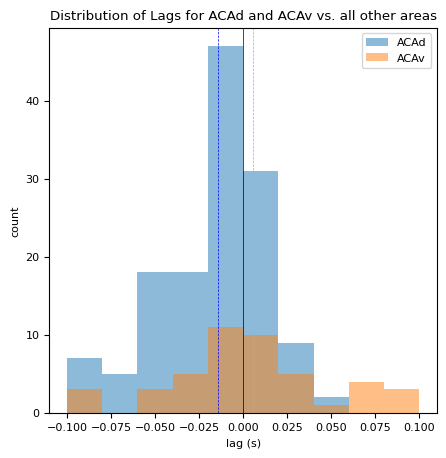

In [8]:
#single area plot

xbins=np.arange(-0.1,0.11,0.02)

fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

sel_structure_1='ACAd'
sel_structure_2='ACAv'

sel_result='vis_target_correct_trials'
values=session_structure_lags.query(f'structure_1=="{sel_structure_1}" and result=="{sel_result}"')['best_lag']
ax.hist(values, bins=xbins, label=sel_structure_1,alpha=0.5)
ax.axvline(x=np.mean(values), color='blue', linestyle='--', linewidth=0.5)

values=session_structure_lags.query(f'structure_1=="{sel_structure_2}" and result=="{sel_result}"')['best_lag']
ax.hist(values, bins=xbins, label=sel_structure_2,alpha=0.5)
ax.axvline(x=np.mean(values), color='orange', linestyle='--', linewidth=0.5)

ax.set_xlabel('lag (s)')
ax.set_ylabel('count')

ax.set_title(f"Distribution of Lags for {sel_structure_1} and {sel_structure_2} vs. all other areas")

ax.legend()

In [ ]:
#mean or median lags vs all other structures


In [48]:
#make lag matrix
sel_result='aud_target_correct_trials'
# sel_result='vis_target_correct_trials'

combine=False #combine across results

custom_include_structures=[
    'ACAd','CP','FRP','MOs','MRN','ORBl','SCm','SSp',
]


unique_structures = session_structure_lags['structure_1'].sort_values().unique()

unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]
if custom_include_structures is not None:
    incl_structures=np.sort(custom_include_structures)
else:
    incl_structures=[]
    for st in unique_structures:
        if (session_structure_lags[['structure_1','structure_2']].value_counts()[st]>=1).sum()>=3:
            incl_structures.append(st)
    incl_structures=np.sort(incl_structures)

#build correlation matrix from this dataframe
lag_matrix = pd.DataFrame(index=incl_structures, columns=incl_structures, dtype=float)
n_sessions_matrix = pd.DataFrame(index=incl_structures, columns=incl_structures, dtype=int)

for structure_1 in incl_structures:
    for structure_2 in incl_structures:
        if structure_1==structure_2:
            lag_matrix.loc[structure_1, structure_2] = np.nan
            n_sessions_matrix.loc[structure_1, structure_2] = 0
            continue
        
        if combine:
            lag = session_structure_lags.query(f'structure_1=="{structure_1}" & structure_2=="{structure_2}"')['best_lag']
        else:
            lag = session_structure_lags.query(f'structure_1=="{structure_1}" & structure_2=="{structure_2}" and result=="{sel_result}"')['best_lag']

        if not lag.empty and len(lag)>=3:
            lag_matrix.loc[structure_1, structure_2] = lag.mean()
            n_sessions_matrix.loc[structure_1, structure_2] = len(lag)
        else:
            lag_matrix.loc[structure_1, structure_2] = np.nan
            n_sessions_matrix.loc[structure_1, structure_2] = 0

lag_matrix

,ACAd,CP,FRP,MOs,MRN,ORBl,SCm,SSp
ACAd,NaN,-0.005500,0.033000,0.004565,3.000000e-02,-0.011250,2.363636e-02,-0.010000
CP,0.005500,NaN,0.020000,0.001061,-2.692308e-03,0.009286,7.647059e-03,-0.021857
FRP,-0.033000,-0.020000,NaN,-0.008636,NaN,-0.012857,-1.666667e-03,-0.020000
MOs,-0.004565,-0.001061,0.008636,NaN,1.300000e-02,-0.013571,1.187500e-02,-0.020370
MRN,-0.030000,0.002692,NaN,-0.013000,NaN,-0.026000,-1.156482e-19,-0.018125
ORBl,0.011250,-0.009286,0.012857,0.013571,2.600000e-02,NaN,1.785714e-02,-0.030625
SCm,-0.023636,-0.007647,0.001667,-0.011875,1.156482e-19,-0.017857,NaN,-0.029000
SSp,0.010000,0.021857,0.020000,0.020370,1.812500e-02,0.030625,2.900000e-02,NaN


In [ ]:
# (session_structure_lags[['structure_1','structure_2']].value_counts()['MOs']>=5).sum()

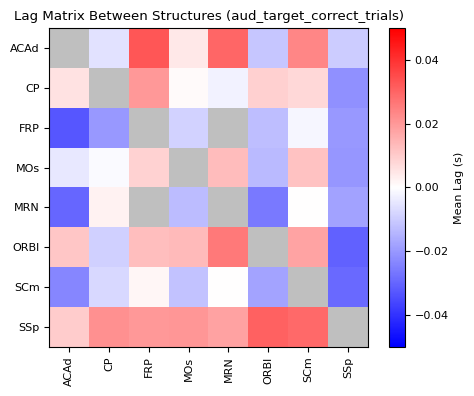

In [49]:
# lag_matrix.mean(axis=0)

masked_array = np.ma.array(lag_matrix, mask=np.isnan(lag_matrix))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(masked_array, cmap=cmap, vmin=-0.05, vmax=0.05)
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_yticks(np.arange(len(incl_structures)))
ax.set_xticklabels(incl_structures, rotation=90)
ax.set_yticklabels(incl_structures)
if combine:
    ax.set_title(f'Lag Matrix Between Structures (combined results)')
else:
    ax.set_title(f'Lag Matrix Between Structures ({sel_result})')

#plot text for n sessions in each square
for i in range(len(incl_structures)):
    for j in range(len(incl_structures)):
        if i != j:
            n_sessions = n_sessions_matrix.loc[incl_structures[i], incl_structures[j]]
            # if n_sessions > 0:
            #     ax.text(j, i, str(int(n_sessions)), ha='center', va='center', color='black')

fig.colorbar(im, ax=ax, label='Mean Lag (s)')
fig.tight_layout()

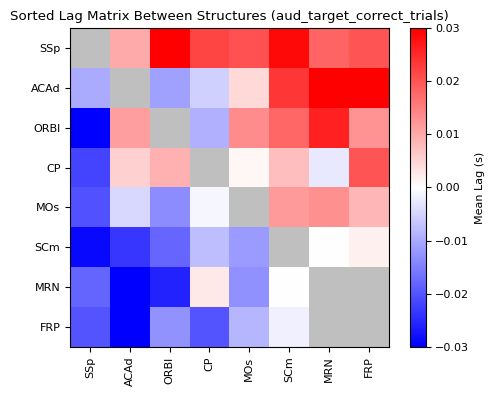

In [50]:
#sort lag matrix by mean col value and mean row value
col_means = lag_matrix.mean(axis=0).sort_values(ascending=False)
row_means = lag_matrix.mean(axis=1).sort_values(ascending=False)
lag_matrix_sorted = lag_matrix.loc[row_means.index, row_means.index]
# row_means = np.sum(lag_matrix<0,axis=1)
# lag_matrix_sorted = lag_matrix.loc[row_means.sort_values().index, row_means.sort_values().index]


masked_array = np.ma.array(lag_matrix_sorted, mask=np.isnan(lag_matrix_sorted))
cmap = matplotlib.cm.bwr
cmap.set_bad('grey',0.5)

fig,ax=plt.subplots(1,1,figsize=(5,4))
im=ax.imshow(masked_array, cmap=cmap, vmin=-0.03, vmax=0.03)
ax.set_xticks(np.arange(len(incl_structures)))
ax.set_yticks(np.arange(len(incl_structures)))
ax.set_xticklabels(lag_matrix_sorted.columns, rotation=90)
ax.set_yticklabels(lag_matrix_sorted.index)
if combine:
    ax.set_title(f'Sorted Lag Matrix Between Structures (combined results)')
else:
    ax.set_title(f'Sorted Lag Matrix Between Structures ({sel_result})')

#plot text for n sessions in each square
for i in range(len(incl_structures)):
    for j in range(len(incl_structures)):
        if i != j:
            n_sessions = n_sessions_matrix.loc[lag_matrix_sorted.index[i], lag_matrix_sorted.columns[j]]
            # if n_sessions > 0:
            #     ax.text(j, i, str(int(n_sessions)), ha='center', va='center', color='black')

fig.colorbar(im, ax=ax, label='Mean Lag (s)')
fig.tight_layout()

In [51]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-12-01-plots_for_DR_PAC\decoding_lag_matrix_aud_target_sorted.png'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='png', pad_inches=0.1)

In [ ]:
# np.sum(lag_matrix<0,axis=1)